# Recurrent Neural Networks: Example 1 - Clothing Sales Dataset

In this noteboook a real time series dataset is used to build a model and forecast future values.

The dataset was downloaded from the FRED website with data on **Retail Sales: Clothing and Clothing Accessory Stores (Not Seasonally Adjusted)**:

[https://fred.stlouisfed.org/series/RSCCASN](https://fred.stlouisfed.org/series/RSCCASN)

Note that the COVID-19 changes the expected course of the data; therefore, I used the CSV from J.M. Portilla's course, which can be found in the `data` folder:

`../../data/RSCCASN.csv`

`git_repositories/data_science_python_tools/data/RSCCASN.csv`

**Important note 1: it makes sense to have date information instead of date strings to fully handle the time series.
Therefore, often date strings need to be converted into datetime type.**

**Important note 2: few comments are added here; to see more detailed notes, look at previous notebook.**

In [30]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## 1. Load and prepare the dataset

In [8]:
# We load the dataset
# We convert the date string to datetime type on the fly
# and be set that column to be the index
df = pd.read_csv('../../data/RSCCASN.csv',parse_dates=True,index_col='DATE')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [10]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [14]:
# We change the name of the column so that it's easier to remember
# Note that it contains sales in millions by day
df.columns = ['Sales']

In [15]:
df.head()

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


<AxesSubplot:xlabel='DATE'>

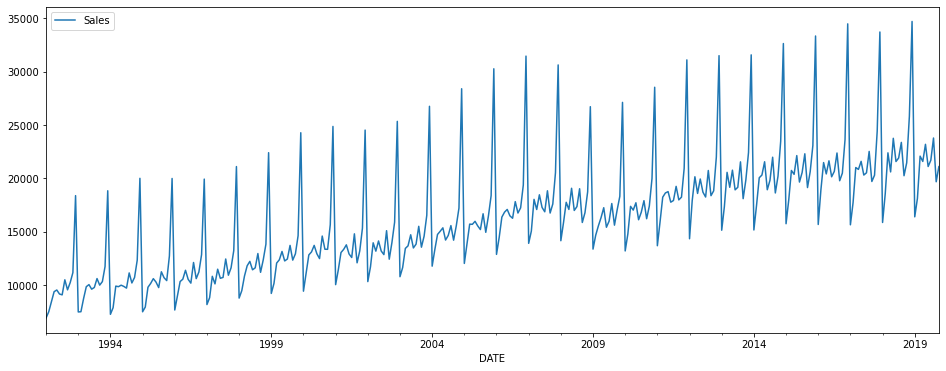

In [36]:
# We can see that a year (12 months or data points) y a cycle or period
# which contains the major trend and a seasonality components.
# Thus, we need to take that time span into consideration for splitting
df.plot(figsize=(16,6))

### Train/Test Split

In [22]:
# Due to the observation above,
# we split in the last 1.5 years = 18 months
len(df)

334

In [23]:
test_size = 18
test_ind = len(df) - test_size

In [37]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

### Scaling

In [25]:
# Now, we need to scale our data
from sklearn.preprocessing import MinMaxScaler

In [26]:
scaler = MinMaxScaler()

In [27]:
scaler.fit(train)

MinMaxScaler()

In [28]:
scaled_train = scaler.transform(train)

In [38]:
scaled_test = scaler.transform(test)

### Generator

In [32]:
# Time series generator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [58]:
# The length of the input series must be smaller than the length of the test split
# if we do early-stopping validdation
length = 12
batch_size = 1

In [59]:
generator = TimeseriesGenerator(data=scaled_train,
                                targets=scaled_train,
                                length=length,
                                batch_size=batch_size)

In [46]:
# We check the first (X,y) pair of the generator
X,y = generator[0]

In [47]:
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [48]:
y

array([[0.02047633]])

## 2. Create the Model

In [49]:
from tensorflow.keras.models import Sequential

In [50]:
from tensorflow.keras.layers import Dense,SimpleRNN,LSTM

In [54]:
n_features = 1
model = Sequential()
#model.add(SimpleRNN(units=100,input_shape=(length,n_features)))
# We explicitly use the ReLu activation
model.add(LSTM(units=100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

### Early Stopping

In [60]:
from tensorflow.keras.callbacks import EarlyStopping

In [61]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [63]:
# We need to create a validation generator
# The length is the same as before,
# taking into account that it must be shorter than the length of the validation split
validation_generator = TimeseriesGenerator(scaled_test,
                                          scaled_test,
                                          length=length,
                                          batch_size=1)

### Train

In [64]:
# We train with an early stop callback
model.fit_generator(generator,
                    epochs=20,
                    validation_data=validation_generator,
                    callbacks=[early_stop])

Epoch 1/20
304/304 [==============================] - 45s 148ms/step - loss: 0.0253 - val_loss: 0.0462
Epoch 2/20
304/304 [==============================] - 45s 148ms/step - loss: 0.0190 - val_loss: 0.0225
Epoch 3/20
304/304 [==============================] - 45s 148ms/step - loss: 0.0102 - val_loss: 9.9038e-04
Epoch 4/20
304/304 [==============================] - 44s 146ms/step - loss: 0.0056 - val_loss: 0.0012
Epoch 5/20
304/304 [==============================] - 44s 145ms/step - loss: 0.0020 - val_loss: 0.0024


In [65]:
# We get the loss values and plot them
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

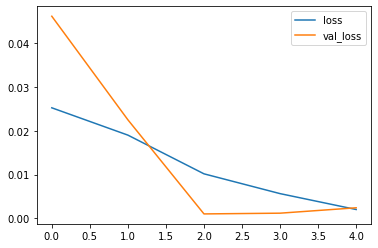

In [66]:
losses.plot()

## 3. Forecasting

In [71]:
# We forecast one by one all the values in the test split
# For that, the batch previous to the test split is taken
# a prediction done for it. and then,
# the batch is moved in the time to contain predicted values
test_predictions = []
current_batch = scaled_train[-length:].reshape((1,length,n_features))
for i in range(len(test)):
    predicted = model.predict(current_batch)[0]
    test_predictions.append(predicted)
    current_batch = np.append(current_batch[:,1:,:],[[predicted]],axis=1)

In [72]:
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions

array([[22249.67779207],
       [21094.53404713],
       [21380.018013  ],
       [23363.15227175],
       [20773.62931776],
       [21573.05665922],
       [26054.04674196],
       [36956.61028099],
       [17287.0687561 ],
       [19559.03779316],
       [23109.01752853],
       [21461.18779135],
       [23085.21214867],
       [22042.49382496],
       [22411.41975164],
       [24453.21374989],
       [22032.27885437],
       [23113.18921614]])

In [73]:
test['LSTM Predictions'] = true_predictions

/Users/mxagar/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='DATE'>

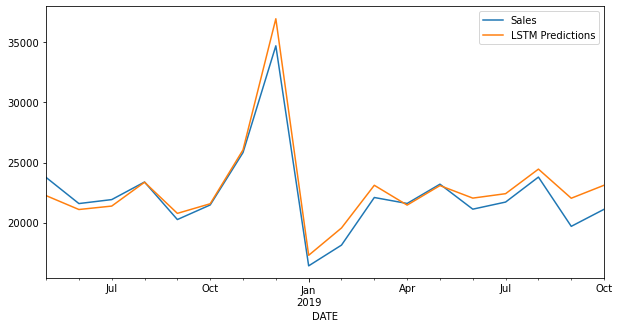

In [74]:
test.plot(figsize=(10,5))